## Open Information Extraction
Open information extraction (open IE) refers to the extraction of relation tuples, typically binary relations, from plain text, such as (Mark Zuckerberg; founded; Facebook). The central difference from other information extraction is that the schema for these relations does not need to be specified in advance; typically the relation name is just the text linking two arguments.
- StanfordOpenIE (https://nlp.stanford.edu/software/openie.html) StanfordOpenIE is part of StanfordCoreNLP, which is built on top of PyTorch 1.0.0. 
 - Therefore, first install pytorch (https://pytorch.org/get-started/locally/), select your  os, package, language, cuda , then use the   command to install.
For example:
 - ``pip install torch==1.11.0+cpu torchvision==0.12.0+cpu -f https://download.pytorch.org/whl/torch_stable.html``
 
 or simply 
 - ``pip install torch==1.11.0+cpu torchvision==0.12.0+cpu -i https://pypi.tuna.tsinghua.edu.cn/simple``
 
 - Install StanfordOpenIE using ``pip install stanford-openie`` (https://pypi.org/project/stanford-openie/)
 - Install Java SE Development Kit 8 (https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html/)
 - Install graphviz : ``conda install python-graphviz``
 - Unzip the stanford-corenlp-full-2018-10-05.zip to the  directory ( C:\Users\youraccount\\.stanfordnlp_resources)

In [1]:
import nltk
from nltk import pos_tag, word_tokenize, ne_chunk, Tree
from openie import StanfordOpenIE
from graphviz import Digraph

### Triple Extraction from text using ``StanfordOpenIE``

In [2]:
# Example code for using StanfordOpenIE in python
from openie import StanfordOpenIE

with StanfordOpenIE() as client:
    text = 'Barack Obama was the 44th president of the United States'
    print('Text: %s.' % text)
    for triple in client.annotate(text):
        print('|-', triple)

Text: Barack Obama was the 44th president of the United States.
Starting server with command: java -Xmx8G -cp /Users/wendywang/.stanfordnlp_resources/stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-2177acbef9334eab.props -preload openie
|- {'subject': 'Barack Obama', 'relation': 'was 44th president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': 'president'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': '44th president'}


For each sentence, StanfordOpenIE will return several triples with high confidence scores. To further refine the results, we can perform filtering by some constraints:
- The subject and object must be named entity from some predfined types
- The relation must be verb or verb phrases (chunk rule)

Come up with your own refinement strategy to get a better result.

In [3]:
def get_labeled_chunks(text):
    # your implementation
    chunks = ne_chunk(pos_tag(word_tokenize(text)), binary = False)
    label_entities = {}
    for i in chunks:
        if type(i) == Tree:
            np = " ".join(a[0] for a in i)
            label_entities[np] = i.label()
    return label_entities

def extract_triple(text):
    # your implementation
    triples = []
    labeled_chunks = list(get_labeled_chunks(text).keys())
    for triple in client.annotate(text):
        # to check whether chunks and openie's entity are similar.
        for i in triple.values():
            if i in labeled_chunks:
                # append them to a list of items.
                triples.append(list(triple.values()))
    return triples

tr = extract_triple(""" Barack Obama was the 44th president of the United States, and the first African American to serve in the office.
          On October 3, 1992,  Barack Obama married  Michelle Robinson at Trinity United Church in Chicago. """)
print("Extracted Triples:", tr)

Extracted Triples: [['Barack Obama', 'was 44th president of', 'United States'], ['Barack Obama', 'was 44th president of', 'United States'], ['Barack Obama', 'was president of', 'United States'], ['Barack Obama', 'was president of', 'United States'], ['Barack Obama', 'was', 'president'], ['Barack Obama', 'was', '44th president'], ['Trinity United Church', 'is in', 'Chicago'], ['Trinity United Church', 'is in', 'Chicago'], ['Barack Obama', 'married', 'Michelle Robinson'], ['Barack Obama', 'married', 'Michelle Robinson'], ['Barack Obama', 'married Michelle Robinson at', 'Trinity United Church'], ['Barack Obama', 'married Michelle Robinson at', 'Trinity United Church'], ['Barack Obama', 'married Michelle Robinson at', 'Trinity United Church in Chicago'], ['Barack Obama', 'married Michelle Robinson On', 'October 3 1992']]


### Construct the KB from Triples
Given the knowledge triples, we need to index all the entities and relations, i.e.,get the entity set and relation set, and represent each triple using entity id and relation id.

In [4]:
def KB(triples):
    # your implementation
    # kb_dict = {'Entities': {}, 'Relations': {}, 'Triples': []}
    entity_dict = {}
    relation_dict = {}
    triple_list = []
    entity_counter = 0
    relation_counter = 0
    for item in triples:
        # if item[0] not in entity_dict['Entities'].values():
        #     entity_dict['Entities'][entity_counter] = item[0]
        #     entity_counter += 1
        if item[0] not in entity_dict.values():
            entity_dict[entity_counter] = item[0]
            entity_counter += 1
        if item[2] not in entity_dict.values():
            entity_dict[entity_counter] = item[2]
            entity_counter += 1
        if item[1] not in relation_dict.values():
            relation_dict[relation_counter] = item[1]
            relation_counter += 1
    # for e in triples['subject']:
    #     a = str(entity_dict.keys())[list(entity_dict.values()).index(1)]
    #     triple_list.append([a, b, c])   
    for triple in triples:
        # a = [i[0] for i in entity_item if i[0][1] in str(triple[0].values())]
        i = []
        for (k1, v1) in list(entity_dict.items()):
            if v1 == triple[0]:
                i.append(k1)
                for (k2, v2) in list((relation_dict.items())):
                    if v2 == triple[1]:
                        i.append(k2)
                for (k3, v3) in list((entity_dict.items())):
                    if v3 == triple[2]:
                        i.append(k3)
        triple_list.append(i)
    return [entity_dict, relation_dict, triple_list]

kb = KB(tr)
print("Entities:", kb[0], "\nRelations:",kb[1], "\nTriples:",kb[2])

Entities: {0: 'Barack Obama', 1: 'United States', 2: 'president', 3: '44th president', 4: 'Trinity United Church', 5: 'Chicago', 6: 'Michelle Robinson', 7: 'Trinity United Church in Chicago', 8: 'October 3 1992'} 
Relations: {0: 'was 44th president of', 1: 'was president of', 2: 'was', 3: 'is in', 4: 'married', 5: 'married Michelle Robinson at', 6: 'married Michelle Robinson On'} 
Triples: [[0, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 1], [0, 2, 2], [0, 2, 3], [4, 3, 5], [4, 3, 5], [0, 4, 6], [0, 4, 6], [0, 5, 4], [0, 5, 4], [0, 5, 7], [0, 6, 8]]


### Visualize the KB using ``graphviz``
- To render the graph, the dependency is a working installation of ``Graphviz`` (https://www.graphviz.org/download/).
- After installing Graphviz, make sure that its ``bin/`` subdirectory containing the layout commands for rendering graph descriptions (dot, circo, neato, etc.) is on your systems’ path: On the command-line, ``dot -V`` should print the version of your Graphiz installation.
- Refer to https://graphviz.readthedocs.io/en/stable/manual.html for the user guid of graphviz

In [5]:
import graphviz

def visualizeKB(kb_input):
    # your implementation
    dot = graphviz.Digraph('round-table', comment='The Round Table')
    # help(dot.edge)
    for i in kb_input[2]:
        # fetch info from kb_input, according to dict it returns.
        sub = kb_input[0][i[0]]
        sub_index = str(i[0])
        obj = kb_input[0][i[2]]
        obj_index = str(i[2])
        relation_label = kb_input[1][i[1]]
        # construct the node of the graph,
        # start from subject and end with object.
        dot.node(sub_index, sub)
        dot.node(obj_index, obj)
        # construct the edge of the graph, assign the relation on it.
        dot.edge(sub_index, obj_index, label = relation_label)
    return dot
dot = visualizeKB(kb)
print(dot.source)

// The Round Table
digraph "round-table" {
	0 [label="Barack Obama"]
	1 [label="United States"]
	0 -> 1 [label="was 44th president of"]
	0 [label="Barack Obama"]
	1 [label="United States"]
	0 -> 1 [label="was 44th president of"]
	0 [label="Barack Obama"]
	1 [label="United States"]
	0 -> 1 [label="was president of"]
	0 [label="Barack Obama"]
	1 [label="United States"]
	0 -> 1 [label="was president of"]
	0 [label="Barack Obama"]
	2 [label=president]
	0 -> 2 [label=was]
	0 [label="Barack Obama"]
	3 [label="44th president"]
	0 -> 3 [label=was]
	4 [label="Trinity United Church"]
	5 [label=Chicago]
	4 -> 5 [label="is in"]
	4 [label="Trinity United Church"]
	5 [label=Chicago]
	4 -> 5 [label="is in"]
	0 [label="Barack Obama"]
	6 [label="Michelle Robinson"]
	0 -> 6 [label=married]
	0 [label="Barack Obama"]
	6 [label="Michelle Robinson"]
	0 -> 6 [label=married]
	0 [label="Barack Obama"]
	4 [label="Trinity United Church"]
	0 -> 4 [label="married Michelle Robinson at"]
	0 [label="Barack Obama"]
	4

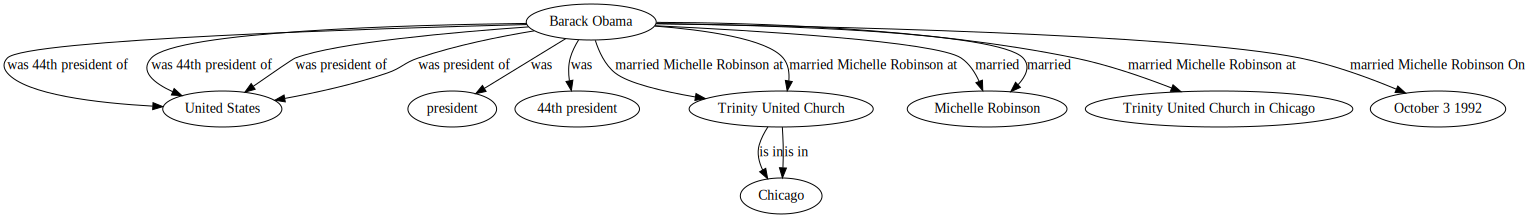

In [6]:
dot.render('kb-demo', view=True) 
dot